In [73]:
import re
import sys
import math
import operator
import os
import glob
import numpy as np
import random
import keras
from keras.applications.resnet50 import ResNet50
from keras.models import Model
from keras.layers import Flatten, Dropout, Dense, Activation
from keras.preprocessing import image
from sklearn.preprocessing import LabelEncoder
from keras.applications.resnet50 import preprocess_input
from PIL import Image

PASCAL_IMAGES = '/Users/chriszhu/Documents/Github/ml/keras/exercises/images/PascalSentenceDataset/dataset/**/**'
PASCAL_SENTENCES = '/Users/chriszhu/Documents/Github/ml/keras/exercises/images/PascalSentenceDataset/sentence/**/**'

def get_data(n=10, size=(224, 224, 3)):
    images = glob.glob(PASCAL_IMAGES)
    random.shuffle(images)
    images = images[0:n]
    # get X data
    X = np.zeros((n, size[0], size[1], size[2]))
    
    for i in range(len(images)):
        path = images[i]
        img = keras.preprocessing.image.load_img(path, target_size=(224, 224))
        x = keras.preprocessing.image.img_to_array(img)

        X[i, :, :, :] = x
        
    # get y data
    classes = [image.split('/')[-2] for image in images]
    classes = LabelEncoder().fit_transform(classes)
    y = np.zeros((n, max(classes) + 1))
    for i in range(len(classes)):
        y[i][classes[i]] = 1
    
    # Get the sentences
    sentence_files = glob.glob(PASCAL_SENTENCES)
    file_name_to_path = { path.split('/')[-1] : path for path in sentence_files}
    
    sentences = []
    for image in images:
        file_name = image.split('/')[-1].split('.')[0] + 'txt'
        path = file_name_to_path[file_name]
        lines = open(path).read().lower().split('\n')[:-1]
        sentences.append(lines)
    return preprocess_input(X), y, images, sentences, classes

def arr2img(arr):
    arr[:, :, 0] += 103.939
    arr[:, :, 1] += 116.779
    arr[:, :, 2] += 123.68
    arr = arr[:, :, ::-1]
    print(arr.shape)
    return Image.fromarray(np.uint8(arr))

Using TensorFlow backend.


['a camouflaged plane sitting on the green grass.', 'a plane painted in camouflage in a grassy field', 'a small camouflaged airplane parked in the grass.', 'camouflage airplane sitting on grassy field.', 'parked camouflage high wing aircraft.']
(224, 224, 3)


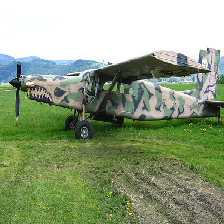

In [76]:
X, y, images, sentences, classes = get_data(30)
print(sentences[0])
arr2img(X[0])


In [11]:
# Lets transfer learn this data
resnet = ResNet50(weights='imagenet')
for layer in resnet.layers:
    layer.trainable = False

x = Dense(256, activation='relu')(resnet.output)
x = Dropout(0.3)(x)
x = Dense(y.shape[1])(x)
x = Activation('softmax')(x)
model = Model(resnet.input, x)
model.compile(
    loss = "categorical_crossentropy",
    optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0),
    metrics=["accuracy"],
)

We want to do something here where we pass all our test images into the network, and extract the values at some layer, and then cluster them based on those activations. But I can't figure out how that works, so lets come back to it and implement the [KL Divergence](http://www.aclweb.org/anthology/W03-1805) stuff

In [60]:
# My attempt at implementing: https://www.trulia.com/blog/tech/organizing-photo-collections-for-visual-browsing/

gamma = 0.8 # parameter for weight of the phraseness component
number_of_terms = 15

foreground_file = '/Users/chriszhu/Documents/Github/ml/keras/exercises/images/PascalSentenceDataset/sentence/cat/2008_003622txt'
background_file = 'tmp/termprofiling/wiki_freqlist.txt'
stopwords = 'tmp/termprofiling/stoplist.txt'

In [61]:
def tokenize(t):
    text = t.lower()
    text = re.sub("\n"," ",text)
    text = re.sub(r'<[^>]+>',"",text) # remove all html markup
    text = re.sub('[^a-zèéeêëėęûüùúūôöòóõœøîïíīįìàáâäæãåçćč&@#A-ZÇĆČÉÈÊËĒĘÛÜÙÚŪÔÖÒÓŒØŌÕÎÏÍĪĮÌ0-9- \']', "", text)
    wrds = text.split()
    return wrds

In [62]:
stoplist = set()
print("Read stopword list")
with open(stopwords) as stoplist_file:
    for line in stoplist_file:
        stopword = line.rstrip()
        stoplist.add(stopword)


Read stopword list


In [63]:
def get_all_ngrams (text,maxn) :
    words = tokenize(text)
    i=0
    terms = dict()
    for word in words :
        if word == "classication":
            word = "classification"
        if word not in stoplist and len(word) > 1 and '@' not in word:
            if word in terms :
                terms[word] += 1
            else :
                terms[word] = 1
        if maxn >= 2 :
            if i< len(words)-1 :
                if words[i] not in stoplist and words[i+1] not in stoplist and words[i+1] != words[i]:
                    bigram = words[i]+ " " +words[i+1]
                    if bigram in terms :
                        terms[bigram] += 1
                    else :
                        terms[bigram] = 1

                if maxn >= 3 :
                    if i < len(words)-2 :
                        if not words[i] in stoplist and not words[i+2] in stoplist and words[i+1] != words[i]:
                            # middle word can be a stopword
                            trigram = words[i]+ " " +words[i+1]+ " " +words[i+2]
                            if trigram in terms :
                                terms[trigram] += 1
                            else :
                                terms[trigram] = 1
        i += 1
    return terms


In [64]:
def filter_ngrams(freq_dict):
    filtered_freq_dict = dict()
    for ngram in freq_dict:
        if re.match("[a-zA-Z]",ngram):
            filtered_freq_dict[ngram] = freq_dict[ngram]
    return filtered_freq_dict

In [65]:
def read_text_in_dict(text):
    freq_dict = get_all_ngrams(text,3)
    freq_dict = filter_ngrams(freq_dict)
    total_term_count = 0
    for key in freq_dict:
        total_term_count += freq_dict[key]
    return freq_dict, total_term_count


In [66]:
def read_columns_in_dict(existing_dict,total_term_count,file,column_with_term,column_with_freq):
    for l in file:
        #print (l)
        columns = l.rstrip().split("\t")
        if re.match("[0-9]+",columns[column_with_freq]):
            t = " ".join(columns[column_with_term])
            freq = int(columns[column_with_freq])
            existing_dict[t] = freq
            total_term_count += freq
    return existing_dict, total_term_count


In [67]:
def print_top_n_terms(score_dict,n):
    sorted_terms = sorted(score_dict.items(),key=operator.itemgetter(1),reverse=True)
    i=0
    for (t,score) in sorted_terms:
        i += 1
        print(t,score)
        if i==n:
            break


In [68]:
print("Read background corpus",background_file)
bg_dict = dict()
bg_term_count = 0

bg = open(background_file,'r')

# parse freqlist
bg_dict,bg_term_count = read_columns_in_dict(bg_dict,bg_term_count,bg,0,1)


('Read background corpus', 'tmp/termprofiling/wiki_freqlist.txt')


In [98]:
def compute_candidate_phrases(fgtext, num_ret=10):
    fg_dict, fg_term_count = read_text_in_dict(fgtext)

    kldiv_per_term = dict()
    for term in fg_dict:
        fg_freq = fg_dict[term]

        # kldivI is kldiv for informativeness: relative to bg corpus freqs
        bg_freq = 1
        if term in bg_dict:
            bg_freq = bg_dict[term]
        relfreq_fg = float(fg_freq)/float(fg_term_count)
        relfreq_bg = float(bg_freq)/float(bg_term_count)

        kldivI = relfreq_fg*math.log(relfreq_fg/relfreq_bg)

        # kldivP is kldiv for phraseness: relative to unigram freqs
        unigrams = term.split(" ")
        relfreq_unigrams = 1.0
        for unigram in unigrams:
            if unigram in fg_dict:
                # stopwords are not in the dict
                u_freq = fg_dict[unigram]
                u_relfreq = float(u_freq)/float(fg_term_count)
                relfreq_unigrams *= u_relfreq
        kldivP = relfreq_fg*math.log(relfreq_fg/relfreq_unigrams)
        kldiv = (1-gamma)*kldivI+gamma*kldivP
        kldiv_per_term[term] = kldiv

    sorted_terms = sorted(kldiv_per_term.items(),key=operator.itemgetter(1),reverse=True)
    return sorted_terms[0:num_ret]

In [130]:
compute_candidate_phrases(open(foreground_file).read())

[('cat', 0.20822659262858653),
 ('striped cat', 0.18026804380329736),
 ('tan domestic kitten', 0.17347815029496347),
 ('resting tan domestic', 0.17347815029496347),
 ('domestic kitten lying', 0.17347815029496347),
 ('tabby cat resting', 0.1508447729705571),
 ('cat resting tan', 0.1508447729705571),
 ('orange tabby cat', 0.1395280843083539),
 ('ginger striped cat', 0.1395280843083539),
 ('striped cat laying', 0.1395280843083539)]

Since we do not have data similar to Trulia, lets just use the Pascal Sentence Dataset: http://vision.cs.uiuc.edu/pascal-sentences/

Downloaded with https://github.com/rupy/PascalSentenceDataset

In [16]:
WORD2_VEC_MODEL = '/Users/chriszhu/Downloads/glove.6B/glove_model2.txt'
model = gensim.models.word2vec.Word2Vec.load_word2vec_format(WORD2_VEC_MODEL, binary=False)
# Do these seem reasonable?
print([x[0] for x in model.most_similar(positive=['king', 'woman'], negative=['man'], topn=10)])
print([x[0] for x in model.most_similar(positive=['king', 'woman'], negative=['man'], topn=10)])

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


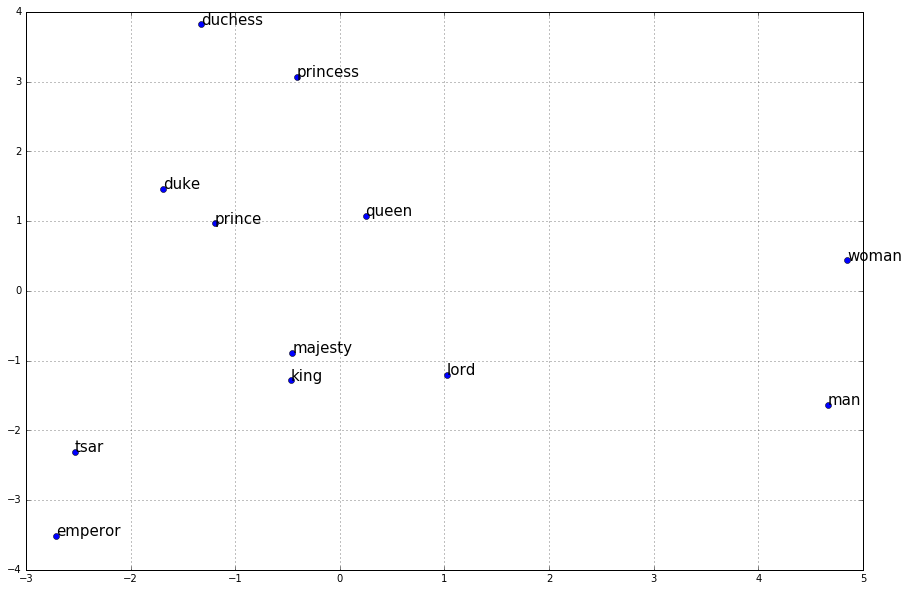

In [55]:
from sklearn.decomposition import PCA
import pandas as pd
import random

ROYALTY_WORDS = [
    'man',
    'woman',
    'prince',
    'princess',
    'king',
    'queen',
    'lord',
    'duke',
    'duchess',
    'majesty',
    'emperor',
    'tsar',
]

royalty_matrix = model[ROYALTY_WORDS]
pca = PCA(n_components=2)
transformed = pca.fit_transform(royalty_matrix)
df = pd.DataFrame(transformed, columns=['x', 'y'])
df['word'] = ROYALTY_WORDS
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 10)
from matplotlib import pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)

plt.plot(df['x'], df['y'], 'o')
i = 0
for x, y in zip(df['x'], df['y']):
    country = df.iloc[i]['word']
    ax.annotate('%s' % country, xy=(x, y), textcoords='data', fontsize=15)
    i += 1

plt.grid()
plt.show()

In [121]:
# I'm 99% sure that adding word vectors like this is meaningless.
def sum_phrase(model, phrase):
    vector = np.zeros(200)
    count = 0.
    for word in phrase.split():
        if word in model:
            vector += model[word]
            count += 1
    return vector / count

In [114]:
def create_reverse_index():
    reverse_index = {}
    
    X, y, images, sentences, classes = get_data(10000)
    for i, image in enumerate(images):
        fgtext = '\n'.join(sentences[i])
        candidate_phrases = compute_candidate_phrases(fgtext)
        #one_word_phrases = [phrase[0] for phrase in candidate_phrases if len(phrase[0].split()) == 1]
        #if len(one_word_phrases) > 0:
        for phrase in candidate_phrases:
            if phrase not in reverse_index:
                reverse_index[phrase[0]] = image
    return reverse_index

reverse_index = create_reverse_index()

In [128]:
print(reverse_index.keys()[1])
vec = sum_phrase(model, reverse_index.keys()[1])

green eyes sits


In [129]:
model.similar_by_vector(vec)

[(u'green', 0.7821657061576843),
 (u'eyes', 0.7664921283721924),
 (u'sits', 0.672528088092804),
 (u'dark', 0.6547145843505859),
 (u'looks', 0.6506248712539673),
 (u'bright', 0.6375294923782349),
 (u'red', 0.637513279914856),
 (u'sitting', 0.6371583938598633),
 (u'beside', 0.6348633766174316),
 (u'blue', 0.6271727681159973)]